#Prob B
1.	For each class, treat images from 0001 to 0040 as train and remaining as test.
2.	Using pretrained resnet18, densenet121, vgg19 models on this dataset, train a 15-class classification model and report per-class classification accuracy in terms of precision and recall. 


In [70]:
# Ensure edits to libraries are loaded and plotting is shown in the notebook.
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [71]:
!git clone https://github.com/Microsoft/computervision-recipes
!pip install -q condacolab
import condacolab
condacolab.install()
!conda env list
!conda install pytorch==1.2.0 torchvision==0.4.0 cudatoolkit=10.0 -c pytorch -y
!conda install bqplot -y

fatal: destination path 'computervision-recipes' already exists and is not an empty directory.
✨🍰✨ Everything looks OK!
# conda environments:
#
base                  *  /usr/local

Solving environment: - \ | / - \ | / - \ | / - \ | / - \ | WARNING conda.core.solve:_add_specs(649): pinned spec cudatoolkit=11.1 conflicts with explicit specs.  Overriding pinned spec.
/ - \ | / - \ | / - \ | / done

# All requested packages already installed.

Solving environment: \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / - \ | / done

# All requested packages already installed.



In [72]:
pip install scrapbook

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [73]:
import sys
#sys.path.append("../../")
sys.path.append("./computervision-recipes")

import numpy as np
from pathlib import Path
import scrapbook as sb

# fastai and torch
import fastai
from fastai.metrics import accuracy
from fastai.vision import (
    models, ImageList, imagenet_stats, partial, cnn_learner, ClassificationInterpretation, to_np,
)

# local modules
from utils_cv.classification.model import TrainMetricsRecorder
from utils_cv.classification.plot import plot_pr_roc_curves
from utils_cv.classification.widget import ResultsWidget
from utils_cv.classification.data import Urls
from utils_cv.common.data import unzip_url
from utils_cv.common.gpu import db_num_workers, which_processor

print(f"Fast.ai version = {fastai.__version__}")
which_processor()

Fast.ai version = 1.0.61
Cuda is not available. Torch is using CPU


In [74]:
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/MyDrive/dataset1.zip

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/MyDrive/dataset1.zip


In [75]:
import zipfile
zip_ref = zipfile.ZipFile("/content/gdrive/MyDrive/dataset1.zip", 'r')
zip_ref.extractall("/tmp")
zip_ref.close()


In [76]:
### test directory
!ls "/tmp/test"
###train Directory
!ls "/tmp/train"


accordion  crocodile	   dollar_bill	hedgehog  pyramid
bass	   crocodile_head  emu		nautilus  sea_horse
camera	   cup		   gramophone	pizza	  windsor_chair
accordion  crocodile	   dollar_bill	hedgehog  pyramid
bass	   crocodile_head  emu		nautilus  sea_horse
camera	   cup		   gramophone	pizza	  windsor_chair


In [77]:

#DATA_PATH     = unzip_url("https://drive.google.com/file/d/1l-KwIglyWJT95JScaL-7BLt8zQcSvv2A", exist_ok=True)
EPOCHS        = 10
LEARNING_RATE = 1e-4
IM_SIZE       = 300

BATCH_SIZE    = 20
ARCHITECTURE  = models.resnet18

In [101]:
data = (
    ImageList.from_folder("/tmp/train")
    #ImageList.from_folder(train = "/tmp/train", valid = "/tmp/test")
    .split_by_rand_pct(valid_pct=0.2, seed=10)
    
    .label_from_folder()
    .transform(size=IM_SIZE)
    .databunch(bs=BATCH_SIZE, num_workers = db_num_workers())
    .normalize(imagenet_stats)
)

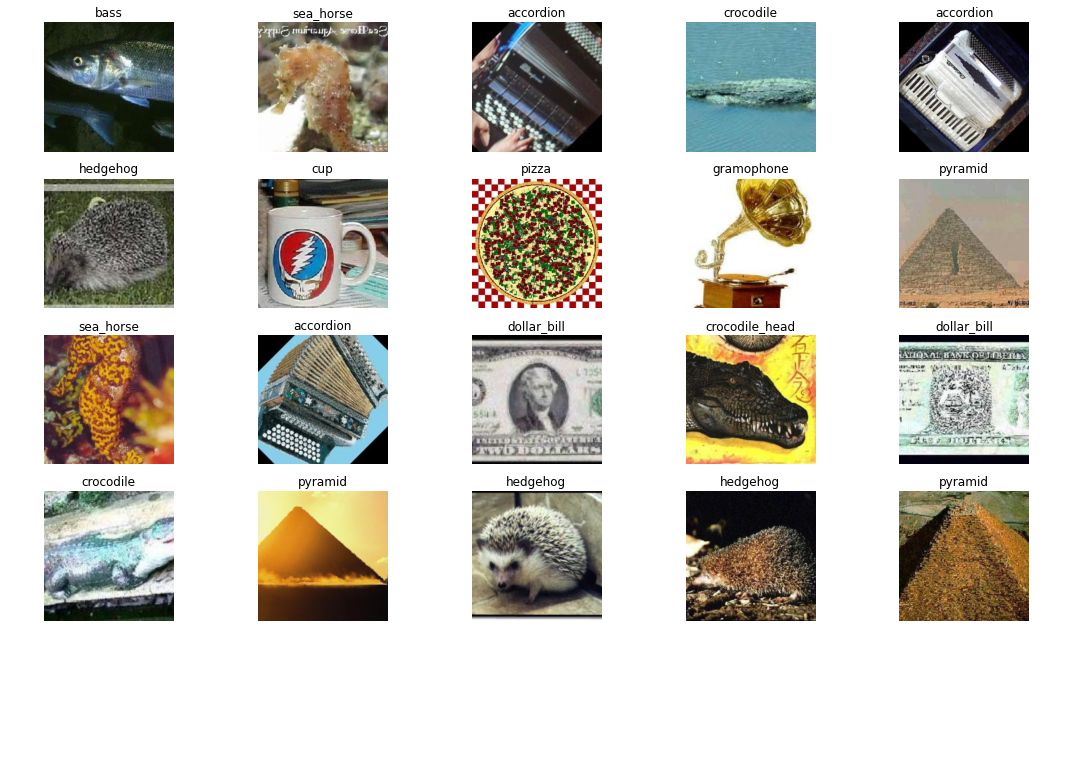

In [79]:
data.show_batch(rows=5, figsize=(15,11))

In [80]:
print(f'number of classes: {data.c}')
print(data.classes)

number of classes: 15
['accordion', 'bass', 'camera', 'crocodile', 'crocodile_head', 'cup', 'dollar_bill', 'emu', 'gramophone', 'hedgehog', 'nautilus', 'pizza', 'pyramid', 'sea_horse', 'windsor_chair']


In [81]:
data.batch_stats

<bound method ImageDataBunch.batch_stats of ImageDataBunch;

Train: LabelList (480 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
hedgehog,hedgehog,hedgehog,hedgehog,hedgehog
Path: /tmp/train;

Valid: LabelList (120 items)
x: ImageList
Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300),Image (3, 300, 300)
y: CategoryList
cup,hedgehog,crocodile,windsor_chair,camera
Path: /tmp/train;

Test: None>

# Train a Model

In [82]:
learn = cnn_learner(
    data,
    ARCHITECTURE,
    metrics=[accuracy],
    callback_fns=[partial(TrainMetricsRecorder, show_graph=True)]
)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 73.3MB/s]


In [83]:
learn.unfreeze()

epoch,train_loss,valid_loss,train_accuracy,valid_accuracy,time
0,2.654329,0.987199,0.270833,0.725000,04:18
1,1.515219,0.427207,0.729167,0.883333,04:16
2,0.928748,0.364574,0.897917,0.883333,04:19
3,0.604006,0.276195,0.939583,0.916667,04:13
4,0.412298,0.252602,0.958333,0.933333,04:16
5,0.284687,0.237120,0.975000,0.925000,04:15
6,0.199798,0.238404,0.985417,0.908333,04:12
7,0.139142,0.273009,0.993750,0.908333,04:13
8,0.101319,0.239544,0.995833,0.933333,04:12
9,0.071861,0.226683,0.997917,0.933333,04:13


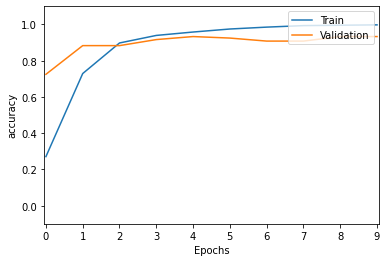

In [84]:
learn.fit(EPOCHS, LEARNING_RATE)

In [86]:
_, validation_accuracy = learn.validate(learn.data.valid_dl, metrics=[accuracy])
print(f'Accuracy on validation set: {100*float(validation_accuracy):3.2f}')

Accuracy on validation set: 93.33


In [87]:
interp = ClassificationInterpretation.from_learner(learn)
# Get prediction scores. We convert tensors to numpy array to plot them later.
pred_scores = to_np(interp.preds)

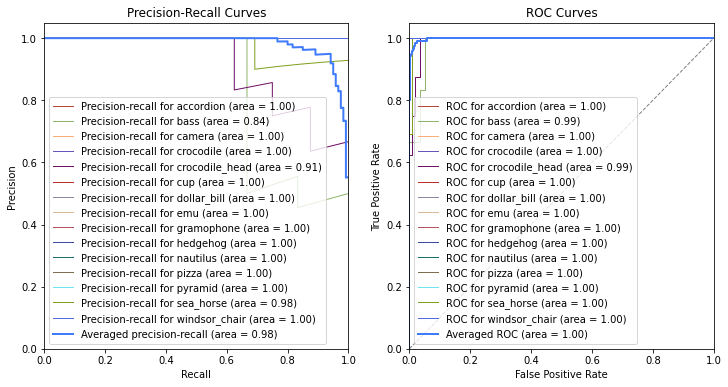

In [89]:
# True labels of the validation set. We convert to numpy array for plotting.
true_labels = to_np(interp.y_true)
plot_pr_roc_curves(true_labels, pred_scores, data.classes)

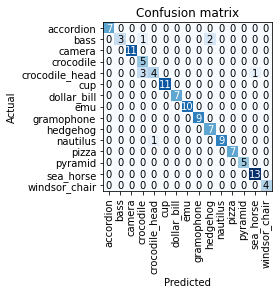

In [90]:
interp.plot_confusion_matrix()

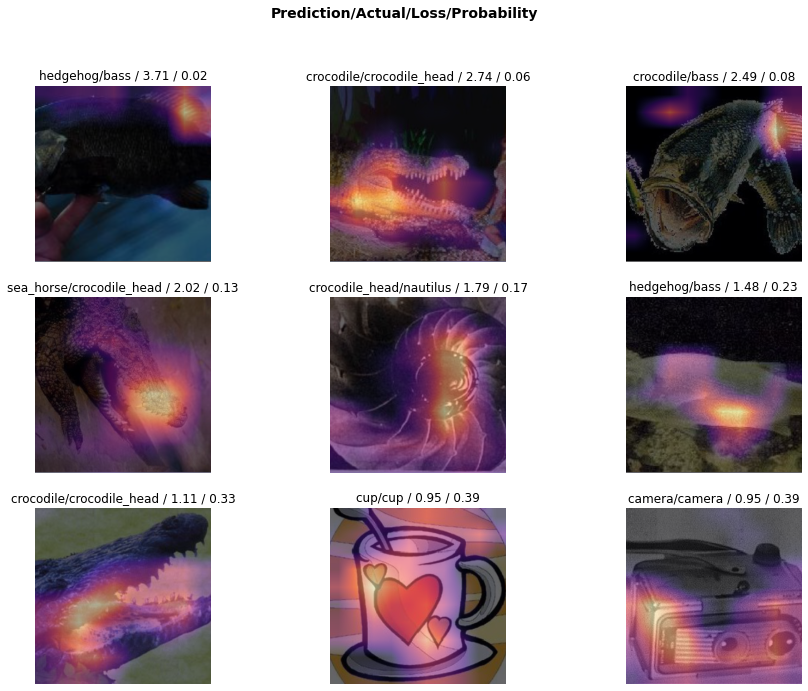

In [91]:
interp.plot_top_losses(9, figsize=(15,11), heatmap=True)